# Calder Lenhart
## ASTRON 3350 Final Project - Computational Notebook


#### Project Description
In this computational notebook, I analyze the line profiles of atomic species in KELT-20b's transmission spectrum. I've integrated this project with my research outside of class.

My workflow thus far has been:
1. Import the spectral data
2. Correct of sources of noise in the data
3. Generate model spectra for atomic species in the atmosphere.
4. Cross-correlate observed spectra with model spectra for all potential atomic/molecular species in the atmosphere -- noting tentative or definite detections (4-sigma and 5-sigma respectively).
5. Correct for the Rossiter-McLaughlin effect.
6. __For detected species, analyze their variations within the atmosphere over the course of transit.__

I've worked on the first five steps previously, although the fifth step is still in progress. The last step is what I intend to do for this final project, doing exploratory data analysis on the line profiles of detected species within the atmosphere. These line profiles are roughly gaussian curves, and I intend to apply a gaussian and/or multi-gaussian fit to them to analyze important properties such as their mean (wind velocity), standard deviation (broadening), amplitude (can correspond to the mechanism in the atmosphere causing them), FWHM, residuals, etc. Using plots of SNR (of the cross-correlations between model and observed spectra) vs phase and residuals (between phase curve and fit) vs phase, I can gather a wealth of information about the underlying dynamics of the atmosphere. This work is essential to my research, and I believe that tying it all in with this class would be perfect, as most of the techniques and analysis we have learned in this class will directly apply. Additionally, many of these visualizations can be employed when presenting my poster at the AAS meeting in January.

__Goals__
1. Generate line profiles + residuals for all species that I've detected and tentatively detected thus far
2. Make gaussian or multi-gaussian fits for each species
3. Analyze the derived parameters, describe all important takeaways for each species, investigate any unexpected outcomes
4. Investigate and quantitatively conclude which mechanisms are behind the wind velocities for each species, using Savel et al. as a reference [1].

__Data__
- Spectra of KELT-20/KELT-20b obtained by PEPSI on LBT
- Model spectra generated by petitRADTRANS

__References__
[1] Savel, A. B., Kempton, E. M. R., Rauscher, E., Komacek, T. D., Bean, J. L., Malik, M., & Malsky, I. (2023). Diagnosing Limb Asymmetries in Hot and Ultrahot Jupiters with High-resolution Transmission Spectroscopy. The Astrophysical Journal, 944(1), 99.


# Generate line profiles + residuals for all species detected and tentatively detected thus far

#### Imports
First, I have to import a bunch of packages necessary to run these precursor functions. Please note that this project is based off some prewritten code for research. My project will largely concern the exploratory data anaylsis aspect of the research. I will submit all of the modules alongside this Jupyter Notebook.

In [7]:
# Imports
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.gridspec as gridspec

from glob import glob
from astropy.io import fits

from scipy.stats import chisquare
from scipy.optimize import curve_fit

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from astropy.table import Table

from uncertainties import ufloat
from uncertainties import unumpy as unp

from atmo_utilities import ccf, one_log_likelihood, log_likelihood_CCF, vacuum2air, log_likelihood_opt_beta

import time

from dtutils import psarr

#from radiant import generate_atmospheric_model, get_wavelength_range

from create_model import create_model, instantiate_radtrans
import horus

from run_all_ccfs import *

%matplotlib inline

First, I'll define a gaussian function to fit to the line profile.

In [8]:
def gaussian(x, a, mu, sigma):

    '''
    Inputs:
    x: x values
    a: amplitude
    mu: mean
    sigma: standard deviation

    Output:
    Gaussian function
    '''
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))


### Preexisting Cross-Correlation Function Plot

I've imported a png of the CCF plot for neutral iron (Fe) in KELT-20b's atmosphere with both the red and blue arms of the PEPSI spectrograph combined. The x-axis is the velocity shift in km/s, and the y-axis is the SNR of the cross-correlation. The peak of the cross-correlation function is the velocity shift of the line profile. The SNR is a measure of the significance of the detection. The higher the SNR, the more significant the detection. The SNR is calculated as the peak of the cross-correlation function divided by the standard deviation of the cross-correlation function.

To anaylze the line profile at the peak of the cross-correlation function, I first fit the Gaussian to each Kp slice (horizontal slice) of the CCF plot. Then, I have an option to pick the Kp slice in two different ways. I can either pick the Kp that corresponds to the expected Kp or the Kp that corresponds to the peak of the cross-correlation function. I will use the latter method for this project. Then, using scipy's curve_fit function, I fit a Gaussian to the line profile. I then plot the line profile and the residuals of the fit. The below code block completes these steps.

<img src="plots/KELT-20b.20190504.combined.Fe.CCFs-shifted-1.png" width="500" height="500">


Here's the explicit logic for the function: 
- Initialization:
    - Check if the spectrograph arm is either 'red' or 'blue'.
    - Initialize empty lists to store fitting parameters (amplitudes, centers, sigmas) and their respective errors.
    - Prepare arrays for storing SNR data slices and their peak values.
- Gaussian Fitting Loop:
    - Iterate over each SNR data slice (from the plotsnr array).
    - Append the current slice and its peak value to Kp_slices and Kp_slice_peak lists.
    - Fit a Gaussian to the current slice using curve_fit, initializing with parameters [5, -7, 1].
    - Store the fitting parameters and their standard deviations (errors) in their respective lists.
- Selecting a Specific Kp Slice:
    - Identify the index of the Kp slice that corresponds to the expected Kp or the one with the maximum SNR.
    - Extract the parameters for this selected slice.
- Plotting the Gaussian Fit and Residuals:
    - Initialize a figure and set up subplots for the main plot and the residuals.
    - Plot the selected SNR data slice and its Gaussian fit.
    - Add species label and other textual information to the plot.
- Generating Plots for V_sys and sigma versus orbital phase:
    - Calculate the orbital phase using planetary parameters and observational data.
    - Create a plot for Vsys using errorbar and fill_between for continuous error representation.
    - Add a secondary axis and plot sigma values with corresponding continuous error regions.
- Saving and Displaying the Plots:
    - Save the SNR-Gaussian fit plot and the Vsys-sigma vs orbital phase plot to the specified file paths.
    - Show the plots for visual inspection


In [17]:
def gaussian_fit(Kp, Kp_true, drv, species_label, planet_name, observation_epoch, arm, species_name_ccf, model_tag, plotsnr):
    """
    Fits a Gaussian to the 1D slice during transit and generates plots.

    Parameters:
    - Kp (array): Array of Kp values.
    - Kp_true (float): True Kp value.
    - drv (array): Array of velocity values.
    - species_label (str): Label for the species.
    - planet_name (str): Name of the planet.
    - observation_epoch (str): Observation epoch.
    - arm (str): Arm of the spectrograph ('red' or 'blue').
    - species_name_ccf (str): Name of the species for cross-correlation function.
    - model_tag (str): Tag for the model.
    - plotsnr (array): Array of SNR values.

    Returns:
    - None
    """
  
    if arm == 'red' or arm == 'blue':   
        # Fitting a Gaussian to the 1D slice during transit

        # Initializing lists to store fit parameters
        amps = []
        amps_err = []
        centers = []
        centers_err = []
        sigmas = []
        sigmas_err = []

        Kp_slices = []
        Kp_slice_peak = []

        residuals = []
        chi2_red = []

        # Fitting gaussian to all 1D Kp slices
        for i in range(plotsnr.shape[0]):
            current_slice = plotsnr[i,:]
            Kp_slices.append(current_slice)
            Kp_slice_peak.append(np.max(current_slice[80:121]))


            popt, pcov = curve_fit(gaussian, drv, current_slice, p0=[5, -7, 1])

            amps.append(popt[0])
            centers.append(popt[1])
            sigmas.append(popt[2])

            # Storing errors (standard deviations)
            amps_err.append(np.sqrt(pcov[0, 0]))
            centers_err.append(np.sqrt(pcov[1, 1]))
            sigmas_err.append(np.sqrt(pcov[2, 2]))


        # Selecting a specific Kp slice
        selected_idx = np.where(Kp == int((np.floor(Kp_true))))[0][0] #Kp slice corresponding to expected Kp
        selected_idx = np.argmax(Kp_slice_peak)                       #Kp slice corresponding to max SNR
        
        # Fitting a Gaussian to the selected slice
        popt_selected = [amps[selected_idx], centers[selected_idx], sigmas[selected_idx]]
        print('Selected SNR:', amps[selected_idx], '\n Selected Vsys:', centers[selected_idx], '\n Selected sigma:', sigmas[selected_idx], '\n Selected Kp:', Kp[selected_idx])
    
        # Computing residuals and chi-squared for selected slice
        residual = plotsnr[selected_idx, :] - gaussian(drv, *popt_selected)
        # chi2 = np.sum((residual / np.std(residual))**2)/(len(drv)-len(popt))

        # Initialize Figure and GridSpec objects
        fig = pl.figure(figsize=(12,8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])

        # Create Axes for the main plot and the residuals plot
        ax1 = pl.subplot(gs[0])
        ax2 = pl.subplot(gs[1], sharex=ax1)
        
        # Main Plot (ax1)
        ax1.plot(drv, plotsnr[selected_idx, :], 'k--', label='data', markersize=2)
        ax1.plot(drv, gaussian(drv, *popt_selected), 'r-', label='fit')

        # Species Label
        ax1.text(0.05, 0.99, species_label, transform=ax1.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)

        pl.setp(ax1.get_xticklabels(), visible=False)
        ax1.set_ylabel('SNR')
        # Annotating the arm and species on the plot
        
        # Additional text information for the main plot
        params_str = f"Peak (a): {popt_selected[0]:.2f}\nMean (mu): {popt_selected[1]:.2f}\nSigma: {popt_selected[2]:.2f}\nKp: {Kp[selected_idx]:.0f}"
        ax1.text(0.01, 0.95, params_str, transform=ax1.transAxes, verticalalignment='top', fontsize=10)

        arm_species_text = f'Arm: {arm}'
        ax1.text(0.15, 0.95, arm_species_text, transform=ax1.transAxes, verticalalignment='top', fontsize=10)
        
        # Vertical line for the Gaussian peak center
        ax1.axvline(x=centers[selected_idx], color='b', linestyle='-', label='Center')



        # Vertical lines for sigma width (center ± sigma)
        #sigma_left = centers[selected_idx] - sigmas[selected_idx]
        #sigma_right = centers[selected_idx] + sigmas[selected_idx]
        #ax1.axvline(x=sigma_left, color='purple', linestyle='--', label='- Sigma')
        #ax1.axvline(x=sigma_right, color='purple', linestyle='--', label='+ Sigma')

        ax1.legend()

        # Add the horizontal line at 4 SNR
        ax1.axhline(y=4, color='g', linestyle='--', label=r'4 $\sigma$')    

        # Inset for residuals (ax2)
        ax2.plot(drv, residual, 'o-', markersize=1)
        ax2.set_xlabel('Velocity (km/s)')
        ax2.set_ylabel('Residuals')

        ax1.set_title('1D CCF Slice + Gaussian Fit')

       
        
        # Consider a clearer naming scheme
        snr_fit = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.SNR-Gaussian.pdf'
        # Save the plot
        fig.savefig(snr_fit, dpi=300, bbox_inches='tight')

        if arm == 'red':
            do_molecfit = True
        else:
            do_molecfit = False

        Period, epoch, M_star, RV_abs, i, M_p, R_p, RA, Dec, Kp_expected, half_duration_phase = get_planet_parameters(planet_name)

        wave, fluxin, errorin, jd, snr_spectra, exptime, airmass, n_spectra, npix = get_pepsi_data(arm, observation_epoch, planet_name, do_molecfit)

        orbital_phase = get_orbital_phase(jd, epoch, Period, RA, Dec)

        phase_min = np.min(orbital_phase)
        phase_max = np.max(orbital_phase)
        phase_array = np.linspace(phase_min, phase_max, np.shape(centers)[0])

        fig, ax1 = pl.subplots(figsize=(12,8))

        ax1.text(0.05, 0.99, species_label, transform=ax1.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)


        ax1.errorbar(phase_array, centers, yerr=centers_err, fmt='o-', label='Center')
        ax1.fill_between(phase_array, centers - centers_err, centers + centers_err, color='blue', alpha=0.2)
        ax1.set_xlabel('Orbital Phase')
        ax1.set_ylabel('Vsys', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.set_title('Vsys and Sigma vs. Orbital Phase')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.plot(phase_array, sigmas, 'r-', label='Sigma')
        ax2.fill_between(phase_array, sigmas - sigmas_err, sigmas + sigmas_err, color='red', alpha=0.2)

        ax2.set_ylabel('Sigma', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        ax2.legend(loc='upper right')


        # Consider a clearer naming scheme
        wind_chars = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.Wind-characteristics.pdf'
        # Save the plot
        #fig.savefig(wind_chars, dpi=300, bbox_inches='tight')
        fig.show()

Next, I'm going to attach a new standalone function to the run_all_ccfs module, which will make a CCF plot shifted into the planetary rest frame. Within this funciton, I will add the Gaussian fit to the 1D line profile. I've noted the portion of the function in which I setup the gaussian fit with the commented in dashes.


In my analysis, I focus on high-resolution spectroscopy data, specifically targeting the red and blue spectrograph arms. Here's an overview of the procedue to complete my Gaussian fit

1. __Gaussian Fitting on 1D SNR Slices__: I fit Gaussian profiles to 1D SNR slices for different planetary radial velocities (Kp).
2. __Parameter Extraction and Error Analysis__: After each fit, I extract parameters amplitude, center, and sigma, and calculate their errors. This quantifies the signal characteristics.
3. __Selecting and Analyzing a Specific Kp Slice__: I choose a Kp slice based on its expected value or peak SNR for a detailed Gaussian fit analysis.
4. __Visualization and Interpretation__: I create plots to visually represent my findings, adding annotations and drawing lines at important points of the Gaussian fit.
5. __Parameters vs Phase__: By calculating various paremeters vs orbital phases, I examine how fit parameters change over time. This is crucial for understanding the atmospheric dynamics, limb asymmetries, and other phenomena.
6. __Saving Results__: I save all the plots and fit parameters to files for future reference and analysis.

In [18]:
def make_shifted_plot(snr, planet_name, observation_epoch, arm, species_name_ccf, model_tag, RV_abs, Kp_expected, V_sys_true, Kp_true, do_inject_model, do_combine, drv, Kp, species_label, temperature_profile, method, plotformat='pdf'):
    """
    Creates a shifted plot of the CCFs or likelihoods for a given planet, observation epoch, arm, and species.

    Args:
    snr (numpy.ndarray): Signal-to-noise ratio of the CCFs or likelihoods.
    planet_name (str): Name of the planet.
    observation_epoch (str): Observation epoch.
    arm (str): Spectrograph arm.
    species_name_ccf (str): Name of the species.
    model_tag (str): Model tag.
    RV_abs (astropy.units.Quantity): Absolute radial velocity.
    Kp_expected (astropy.units.Quantity): Expected Kp.
    V_sys_true (astropy.units.Quantity): True systemic velocity.
    Kp_true (astropy.units.Quantity): True Kp.
    do_inject_model (bool): Whether to inject the model.
    do_combine (bool): Whether to combine the plots.
    drv (astropy.units.Quantity): Radial velocity.
    Kp (astropy.units.Quantity): Kp.
    species_label (str): Species label.
    temperature_profile (str): Temperature profile.
    method (str): Method used to create the plot (either 'ccf' or 'likelihood').
    plotformat (str): Format of the plot file (default is 'pdf').

    Returns:
    None
    """
    
    if method == 'ccf':
        outtag, zlabel = 'CCFs-shifted', 'SNR'
        plotsnr = snr[:]
    if 'likelihood' in method:
        outtag, zlabel = 'likelihood-shifted', '$\Delta\ln \mathcal{L}$'
        plotsnr=snr - np.max(snr)
    plotname = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.' + outtag + '.' + plotformat

    if do_combine:
        plotname = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.' + outtag + '.' + plotformat

    if not do_inject_model:
        apoints = [unp.nominal_values(RV_abs), unp.nominal_values(Kp_expected)]
    else:
        apoints = [V_sys_true, Kp_true]

    if do_inject_model:
        model_label = 'injected'
    else:
        model_label = ''

    if 'transmission' in temperature_profile:
        ctable = 'bone'
    else:
        ctable = 'afmhot'

    keeprv = np.abs(drv-apoints[0]) <= 100.
    plotsnr, drv = plotsnr[:, keeprv], drv[keeprv]
    keepKp = np.abs(Kp-apoints[1]) <= 100.
    plotsnr, Kp = plotsnr[keepKp, :], Kp[keepKp]

    gaussian_fit(Kp, Kp_true, drv, species_label, planet_name, observation_epoch, arm, species_name_ccf, model_tag, plotsnr)    
    psarr(plotsnr, drv, Kp, '$V_{\mathrm{sys}}$ (km/s)', '$K_p$ (km/s)', zlabel, filename=plotname, ctable=ctable, alines=True, apoints=apoints, acolor='cyan', textstr=species_label+' '+model_label, textloc = np.array([apoints[0]-75.,apoints[1]+75.]), textcolor='cyan', fileformat=plotformat)
    
    pl.show()
    

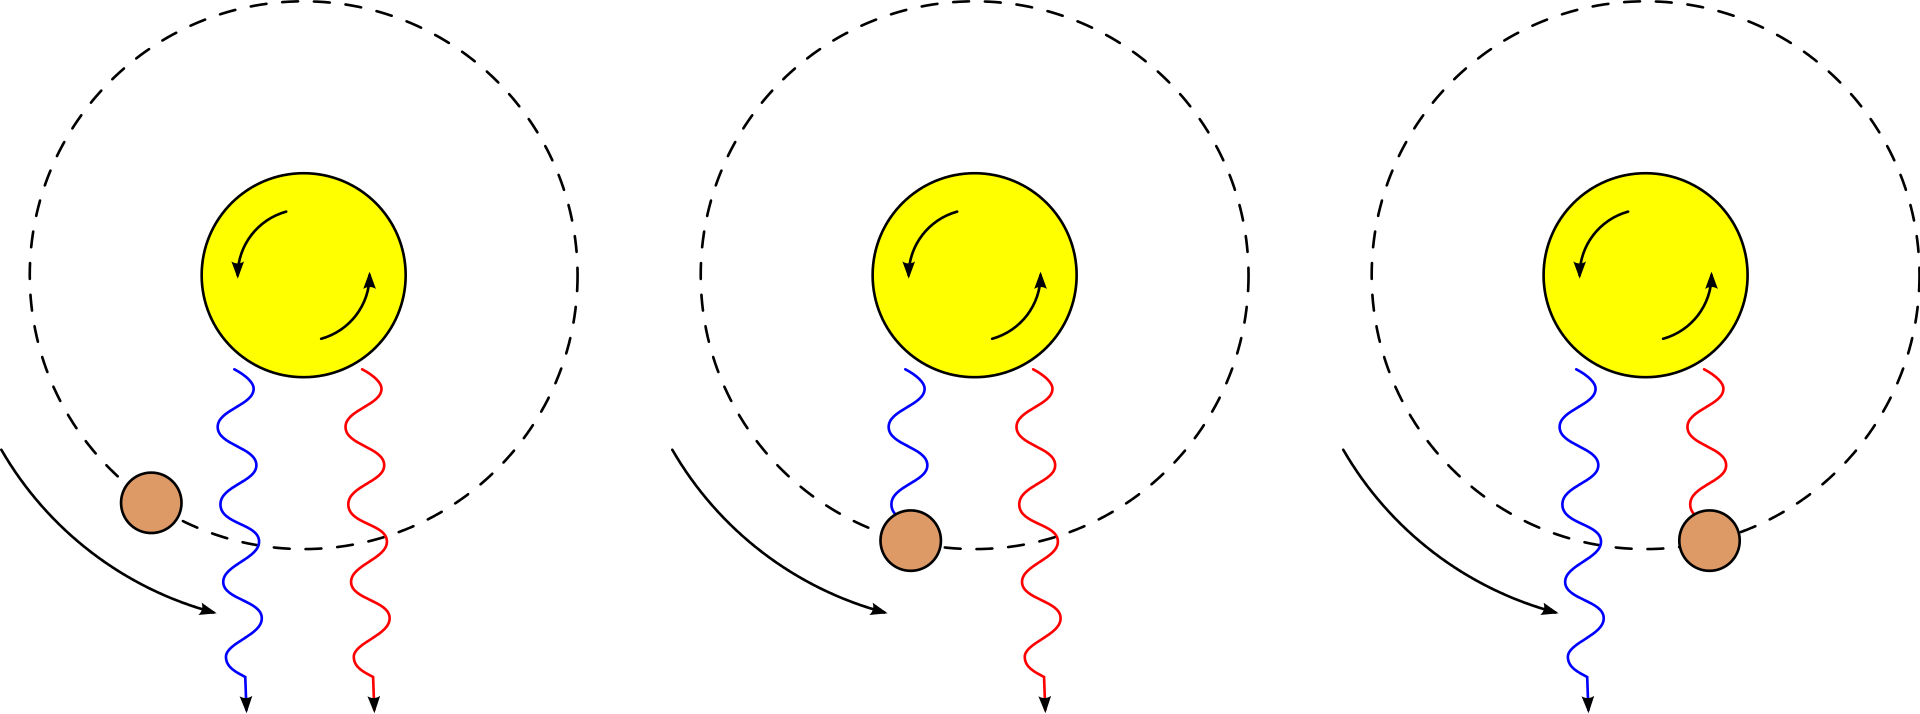

Note the [Rossiter-McLaughlin effect]('https://en.wikipedia.org/wiki/Rossiter%E2%80%93McLaughlin_effect') graphic above. As an exoplanet transits its host star, it will block redshifted or blueshifted light depending on which half of the star it is blocking. This will result in a shift in the line profile of the star. This is a key effect to correct for when analyzing line profiles of atomic species in exoplanet atmospheres, called the Doppler Shadow. Although partially corrected for in other code I've written for this research, it can still influence the line profiles and should be noted.

## Gaussian Fitting on 1D SNR Slices of red and blue arms of Fe I

/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of Fe...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:680: RuntimeWarning: invalid value encountered in sqrt
  kernel = 1. / (np.pi * np.sqrt(1. - velocities**2 / profile_width**2))


Now running the  blue  data for  20190504
The maximum total SNR is  1420.901987322645


/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)


Selected SNR: 14.076769783758172 
 Selected Vsys: -1.1254860491662038 
 Selected sigma: 7.264622930002882 
 Selected Kp: 194
Now running the  red  data for  20190504
The maximum total SNR is  7744.3228985129235


/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1063: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[:,this_one[s]]/corrected_flux[:,this_one[s]]
/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1081: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[ep,this_one]/corrected_flux[ep,this_one]
/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)


Selected SNR: 4.598404916358284 
 Selected Vsys: -2.7010725548537478 
 Selected sigma: 6.02149956379024 
 Selected Kp: 175
Now combining all of the data


<Figure size 640x480 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

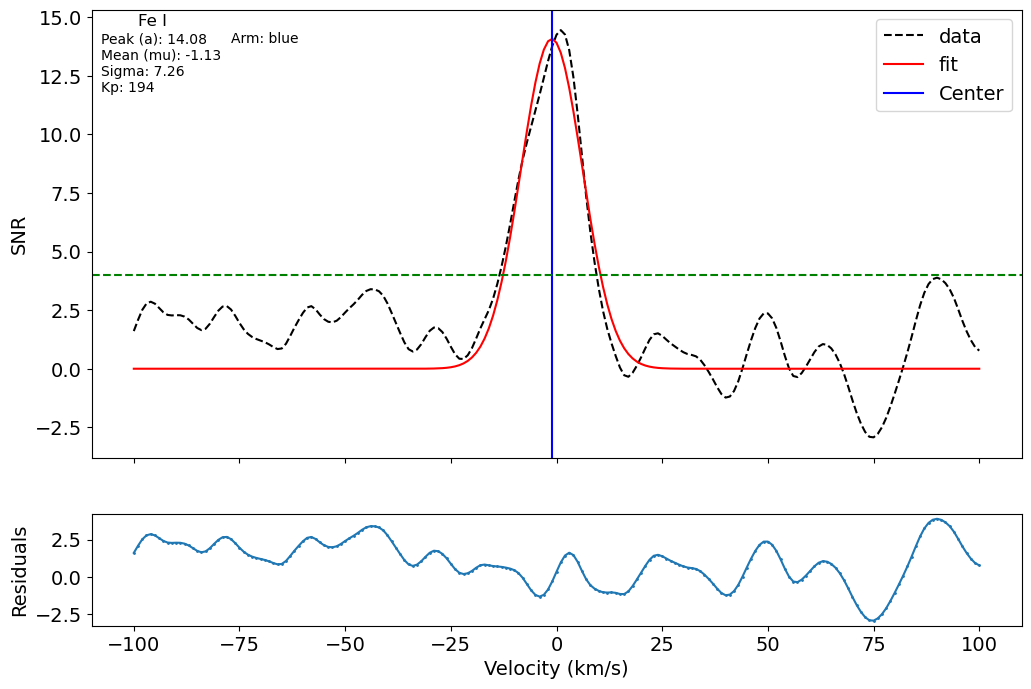

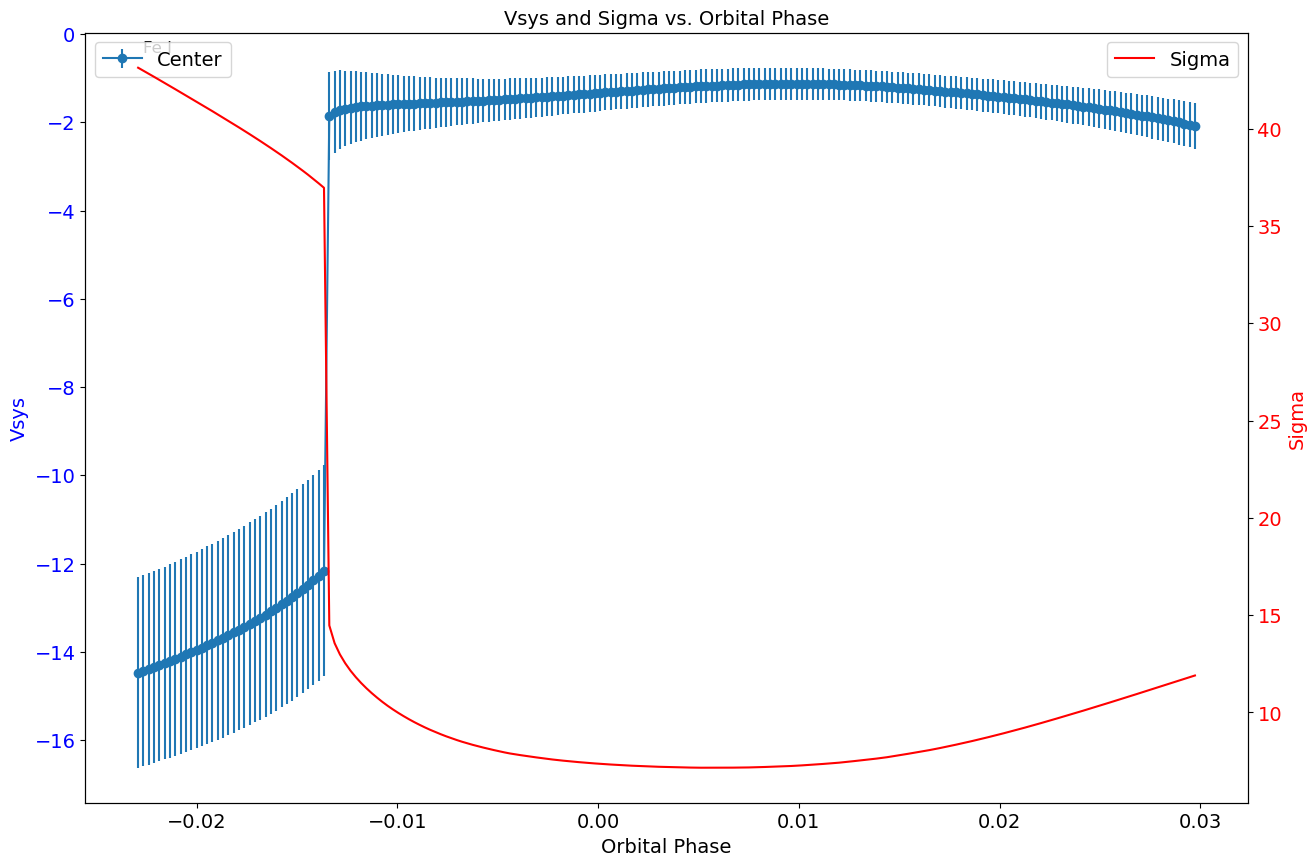

<Figure size 700x700 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

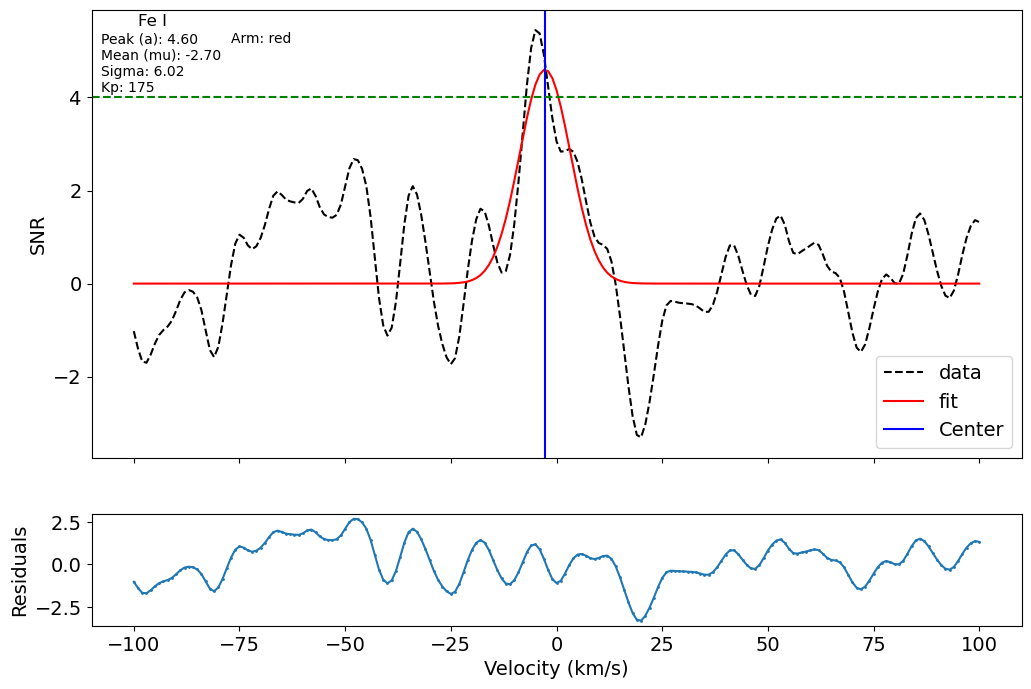

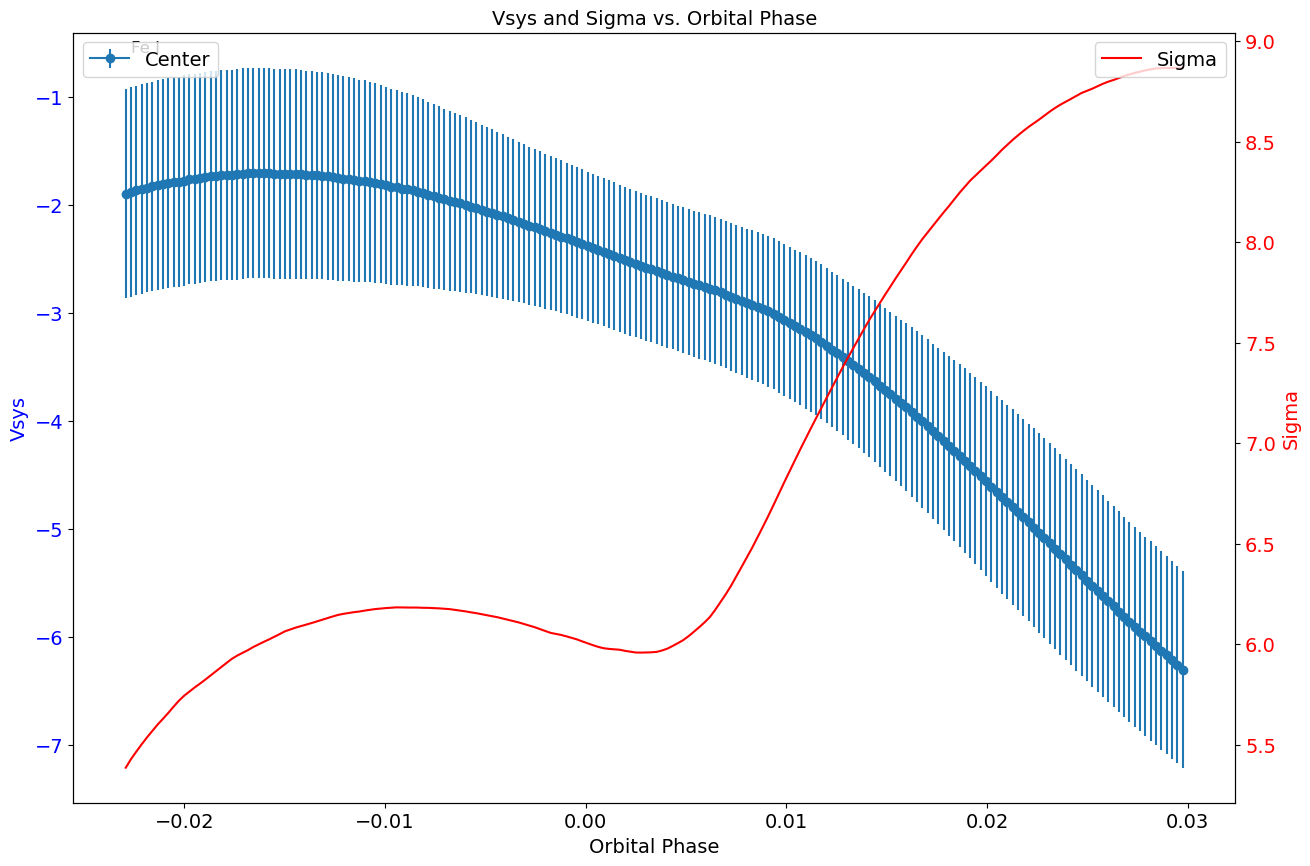

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

In [19]:
run_all_ccfs.make_shifted_plot = make_shifted_plot
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Fe I', 5.39e-05, False, True, True, 'ccf')

### Fe I Discussion

- Red arm
    - SNR peak at Kp = 194km/s, this is our horizontal slice
    - Gaussian fit
        - amplitude (SNR) = 14.08
        - center (V_sys) = -1.13 km/s
        - standard deviation = 7.26 km/s

- Blue arm
    - SNR peak at Kp = 175 km/s
    - Gaussian fit
        - amplitude (SNR) = 4.60
        - center (V_sys) = -2.70 km/s
        - standard deviation = 6.02 km/s

- Limb Asymmetry Analysis
    - The red arm has a much stronger signal than the blue arm. Additionally, the center of 	the blue arm's wind is somewhat more blueshifted, whereas the red arm is somewhat more 		broadened. In the red arm, the species becomes more blueshifted with phase, with a 			significant decrease of -2km/s at the beginning of transit to more than -6km/s at the 		conclusion.  According to [Savel et. al]('https://iopscience.iop.org/article/10.3847/1538-	  4357/acb141/meta') any of the following can cause the aforementioned features:
	  	- Escaping atmosphere: due to a blueshifting CCF with phase.
		- Scale height difference: due to a blueshifting CCF with phase.
		- Weak drag state: blueshifted CCF
		- Cold interior: blueshifted CCF
		- Day-night winds: blueshifted CCF
		- Condensation: strongly blueshifting CCF with phase
		- Tidal deformation/lag: blueshifting CCF with phase
		- T-dependent velocity: blueshifting CCF with phase
		- Clouds: blueshifted CCF

## Gaussian Fits on 1D CCF Slices of red and blue arms of Fe II

/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of Fe+...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:680: RuntimeWarning: invalid value encountered in sqrt
  kernel = 1. / (np.pi * np.sqrt(1. - velocities**2 / profile_width**2))


Now running the  blue  data for  20190504
The maximum total SNR is  1420.901987322645


/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)


Selected SNR: 22.23771721204288 
 Selected Vsys: 0.6120333464305064 
 Selected sigma: 4.886637181989495 
 Selected Kp: 163
Now running the  red  data for  20190504
The maximum total SNR is  7744.3228985129235


/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1063: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[:,this_one[s]]/corrected_flux[:,this_one[s]]
/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1081: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[ep,this_one]/corrected_flux[ep,this_one]
/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)


Selected SNR: 6.366994200066523 
 Selected Vsys: 0.2515254679326236 
 Selected sigma: 5.990545869442052 
 Selected Kp: 150
Now combining all of the data


<Figure size 640x480 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

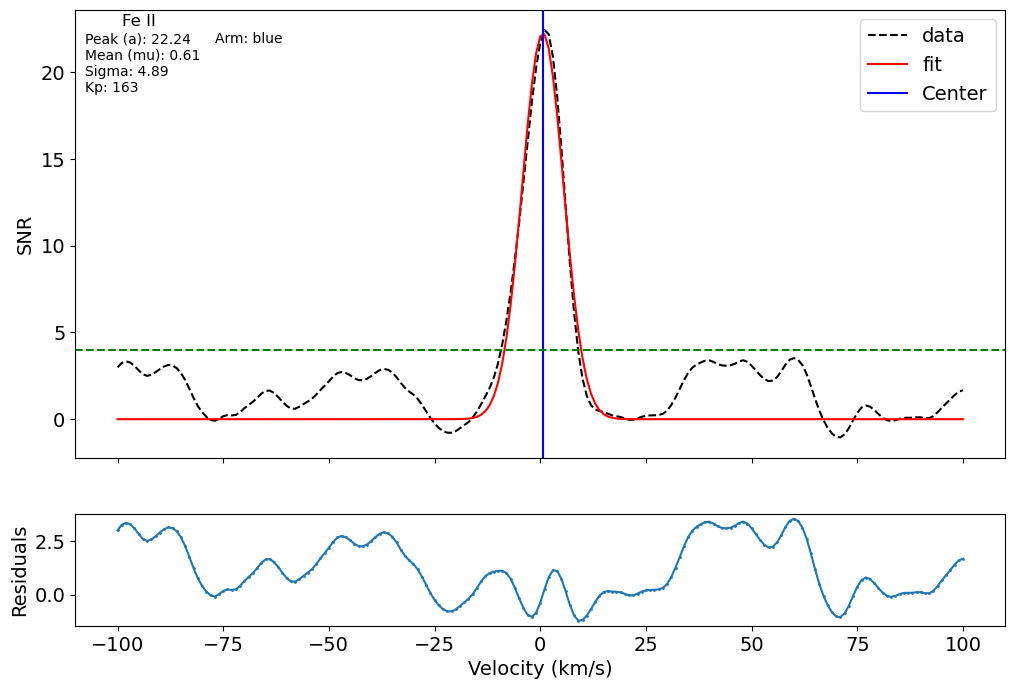

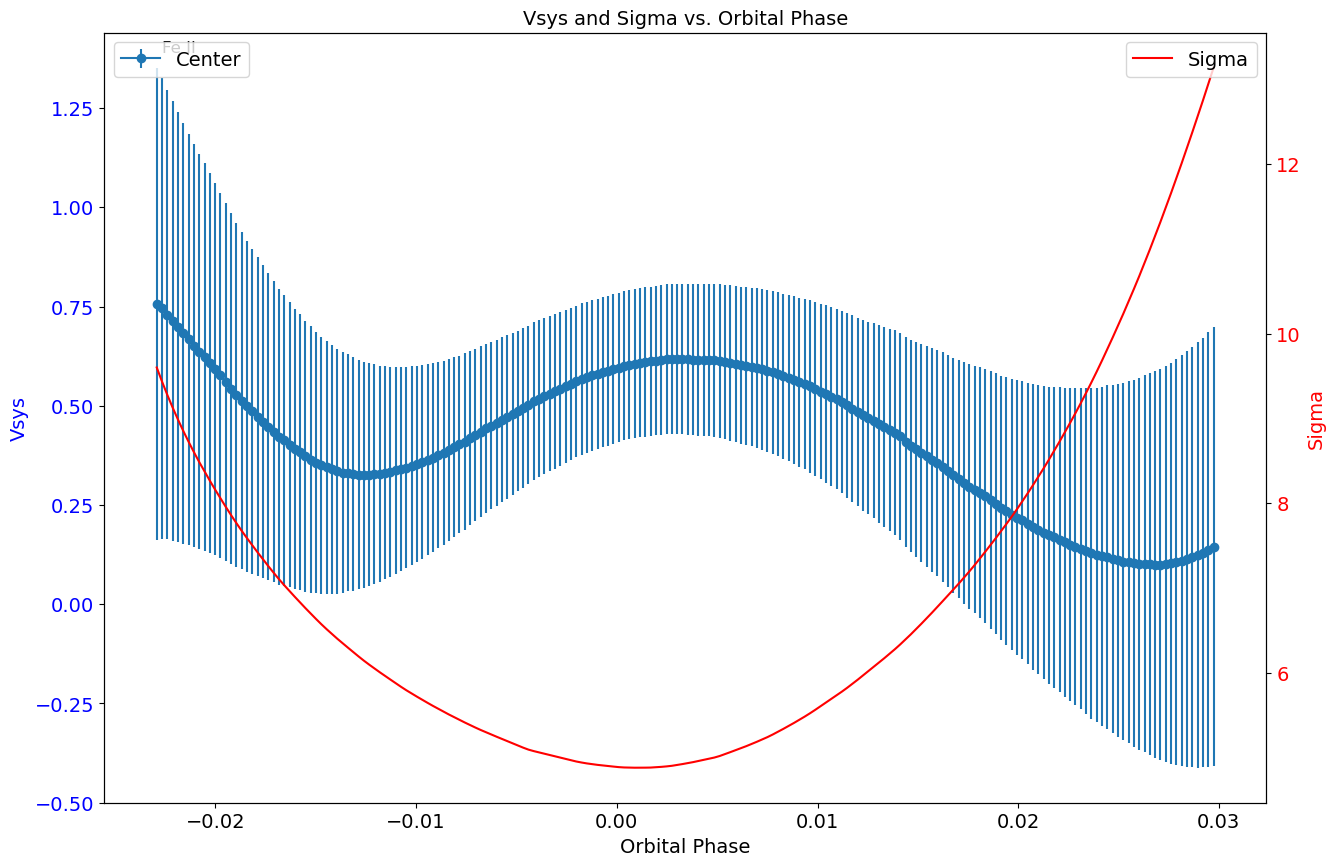

<Figure size 700x700 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

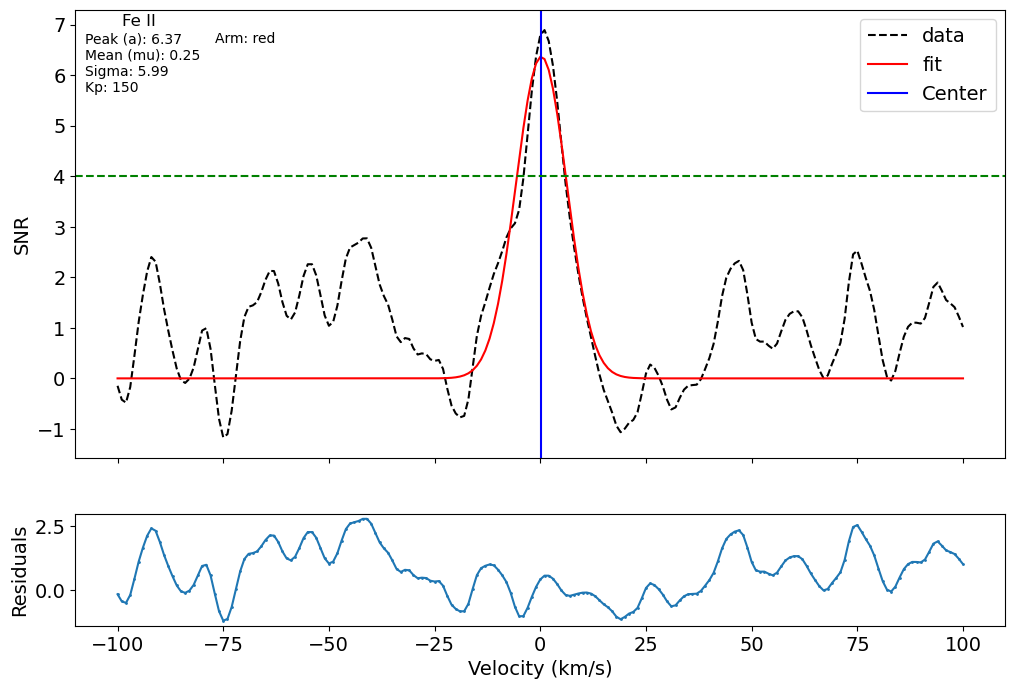

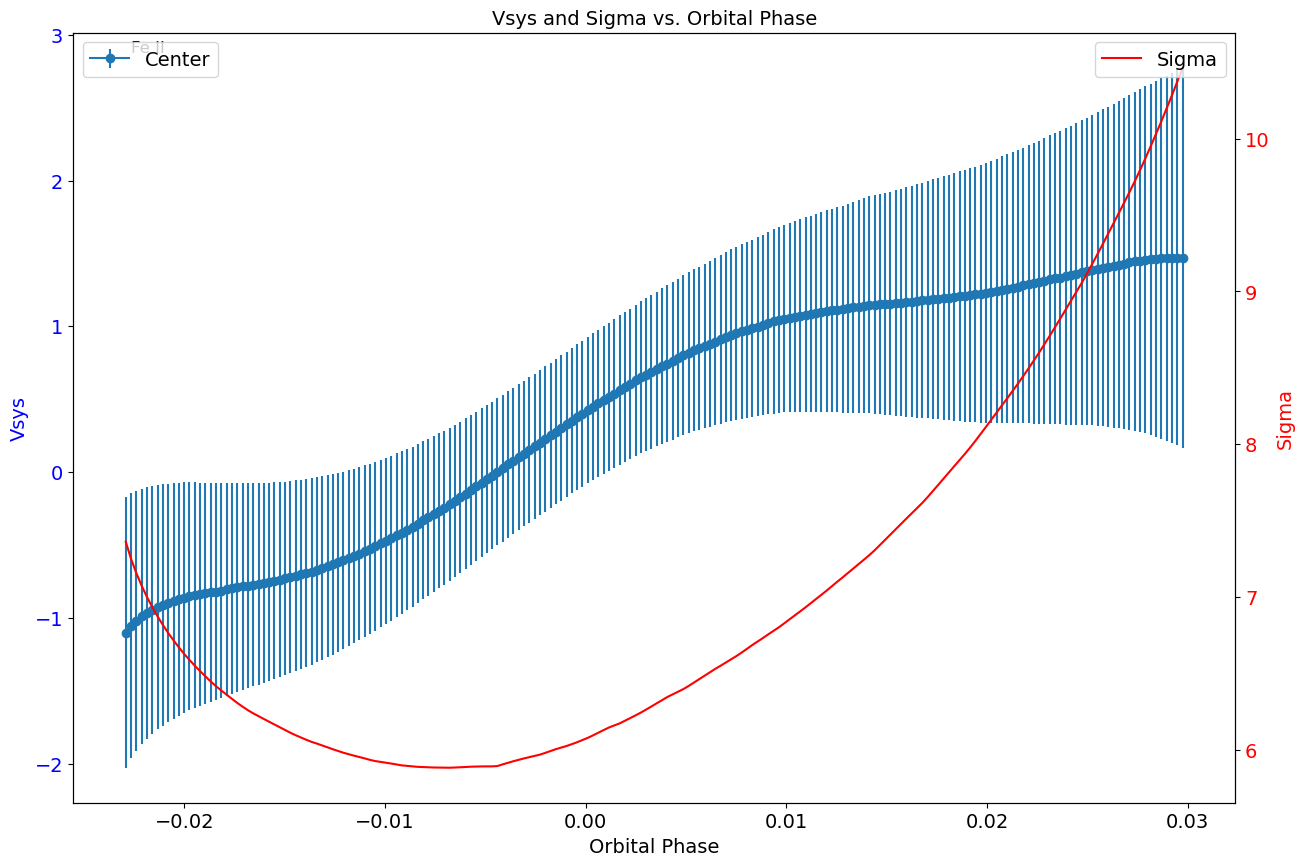

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

In [16]:
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Fe II', 5.39e-05, False, True, True, 'ccf')

### Fe II Discussion
- Red arm
	- SNR: 22.23
	- Vsys: 0.61 km/s
	- Sigma: 4.88 km/s
	- Kp: 163 km/s

- Blue arm
	- SNR: 6.36
	- Vsys: 0.25 km/s
	- Sigma: 5.99 km/s
	- Kp: 150 km/s

- Limb asymmetry analysis
	- The signal from the red arm is again stronger than the blue. Their V_sys's are 			similar, both being near-zero. The blue arm has greater broadening. The red 			  arm becomes steadily less blueshifted with phase.
	- The phase asymmetries are largely negligible for this species. The only significant difference is with signal strength.
		

## Gaussian Fits on 1D CCF Slices of red and blue arms of Ni I

/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of Ni...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:680: RuntimeWarning: invalid value encountered in sqrt
  kernel = 1. / (np.pi * np.sqrt(1. - velocities**2 / profile_width**2))


Now running the  blue  data for  20190504
The maximum total SNR is  1420.901987322645


/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)
/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Selected SNR: 2.9484718336049514 
 Selected Vsys: 0.07148349685416444 
 Selected sigma: 4.339665419549832 
 Selected Kp: 98
Now running the  red  data for  20190504
The maximum total SNR is  7744.3228985129235


/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1063: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[:,this_one[s]]/corrected_flux[:,this_one[s]]
/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1081: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[ep,this_one]/corrected_flux[ep,this_one]
/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)
/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Selected SNR: 3.98316870426856 
 Selected Vsys: -5.082537197217473 
 Selected sigma: 2.7683627235358386 
 Selected Kp: 254
Now combining all of the data


<Figure size 640x480 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

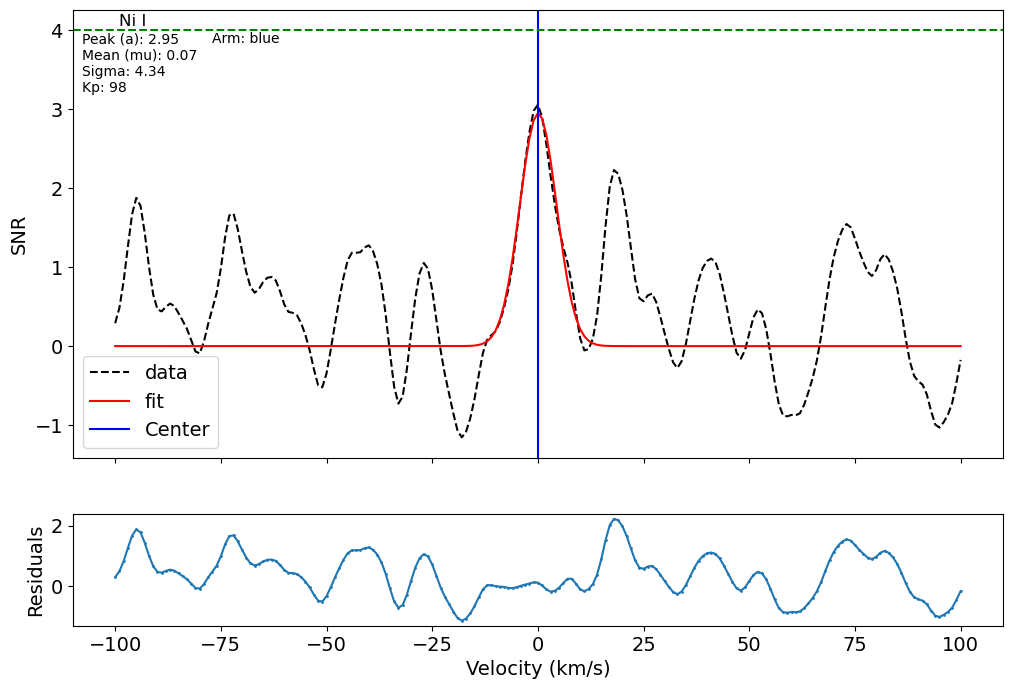

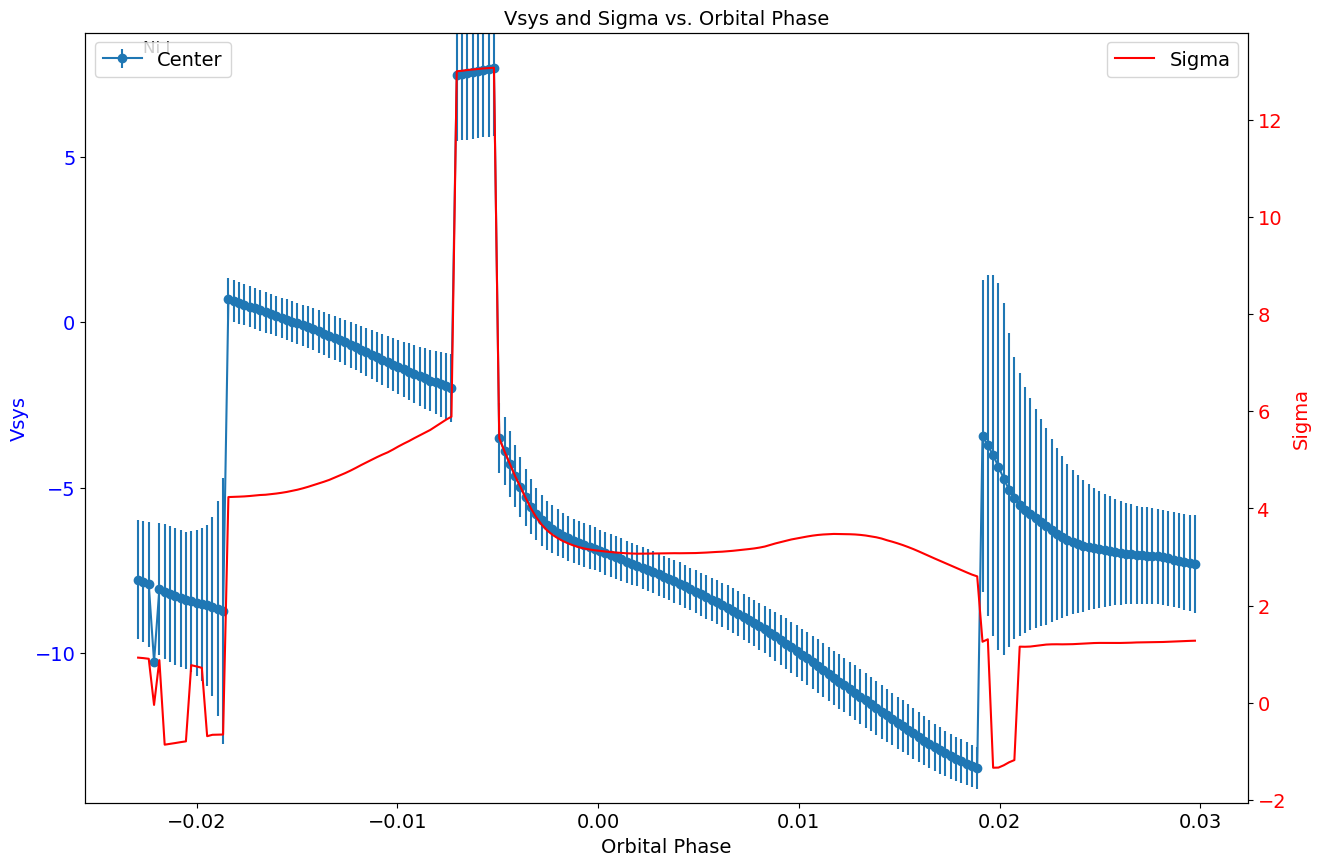

<Figure size 700x700 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

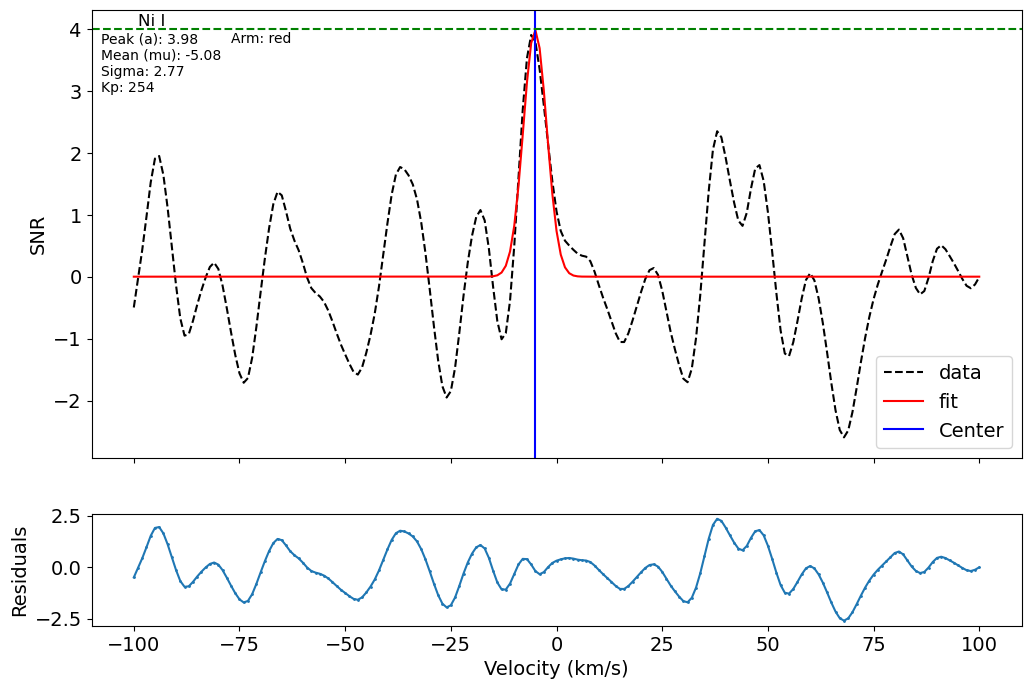

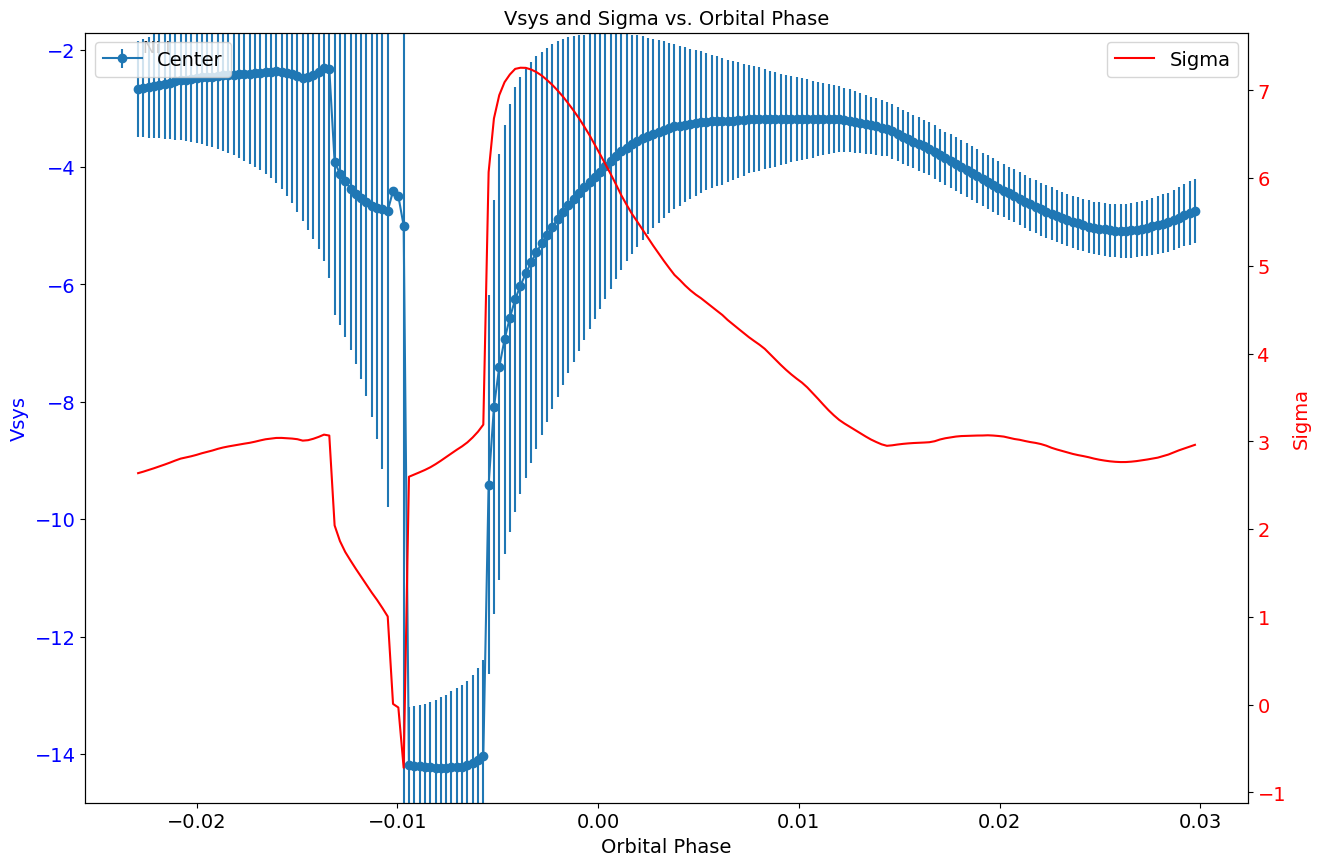

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

In [12]:
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Ni I', 2.67e-06, False, True, True, 'ccf')

### Ni I Discussion
- Red arm
	- SNR: 2.94
	- Vsys: 0.07 km/s
	- Sigma: 4.33 km/s
	- Kp: 98
	
- Blue arm
	- SNR: 3.98
	- Vsys: -5.08 km/s
	- Sigma: 2.76 km/s
	- Kp: 254
- Limb asymmetry analysis
	- Only the blue arm just barely meets the threshold for detection, as signified by the horizontal dashed green like a 4 SNR. Since this is the case, I will be considering the parameters of the blue arm Gaussian with more weight
	- The blue arm Vsys center is at -5k/s, with little variation besides a short deviation in the observation between orbital phase -0.01 and -0.005. 
	- Possible causes of observed feautres, which are all due to blueshifted CCF:
		- Weak drag state
		- Cold interior
		- Day-night winds
		- Clouds



## Gaussian Fits of 1D Slices of red and blue arms of V I

/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of V...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:680: RuntimeWarning: invalid value encountered in sqrt
  kernel = 1. / (np.pi * np.sqrt(1. - velocities**2 / profile_width**2))


Now running the  blue  data for  20190504
The maximum total SNR is  1420.901987322645


/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)


Selected SNR: 2.792328221361996 
 Selected Vsys: -3.2177076081421867 
 Selected sigma: 2.683636617276896 
 Selected Kp: 211
Now running the  red  data for  20190504
The maximum total SNR is  7744.3228985129235


/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1063: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[:,this_one[s]]/corrected_flux[:,this_one[s]]
/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1081: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[ep,this_one]/corrected_flux[ep,this_one]
/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)


Selected SNR: 1.3954874008731375 
 Selected Vsys: -5.503833037122001 
 Selected sigma: 2.680200727836069 
 Selected Kp: 269
Now combining all of the data


<Figure size 640x480 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

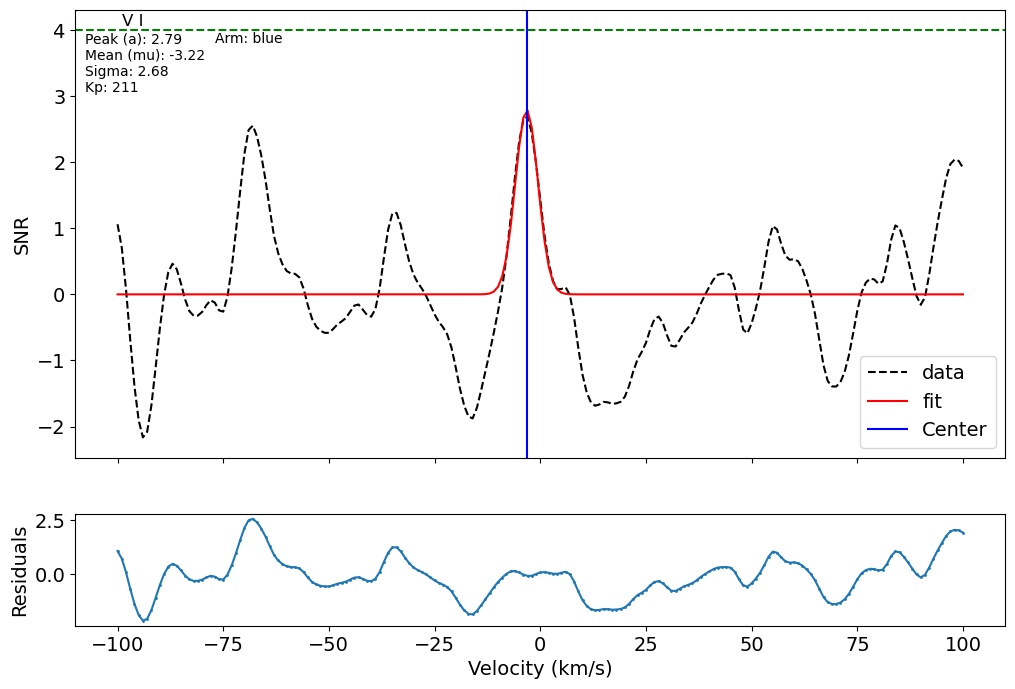

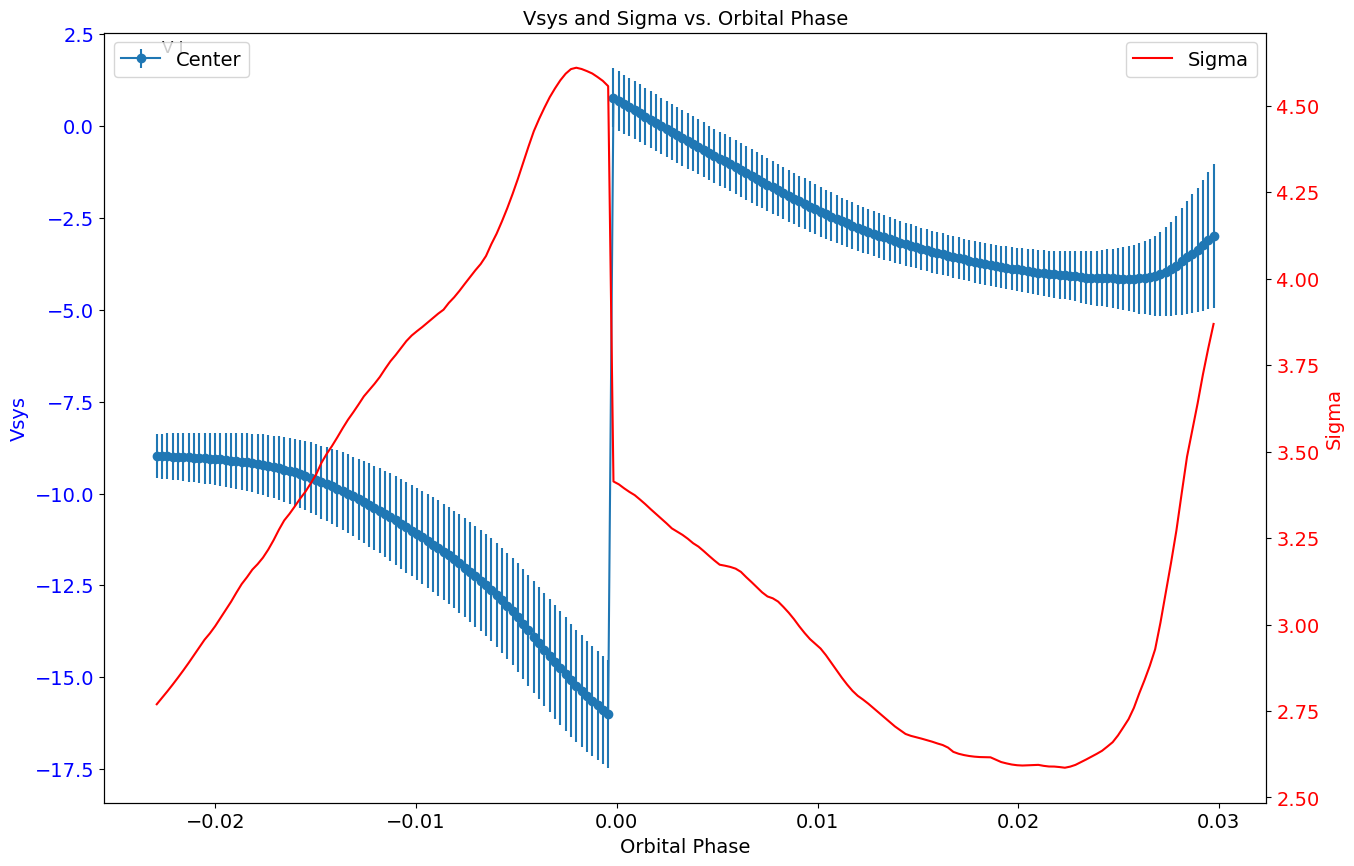

<Figure size 700x700 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

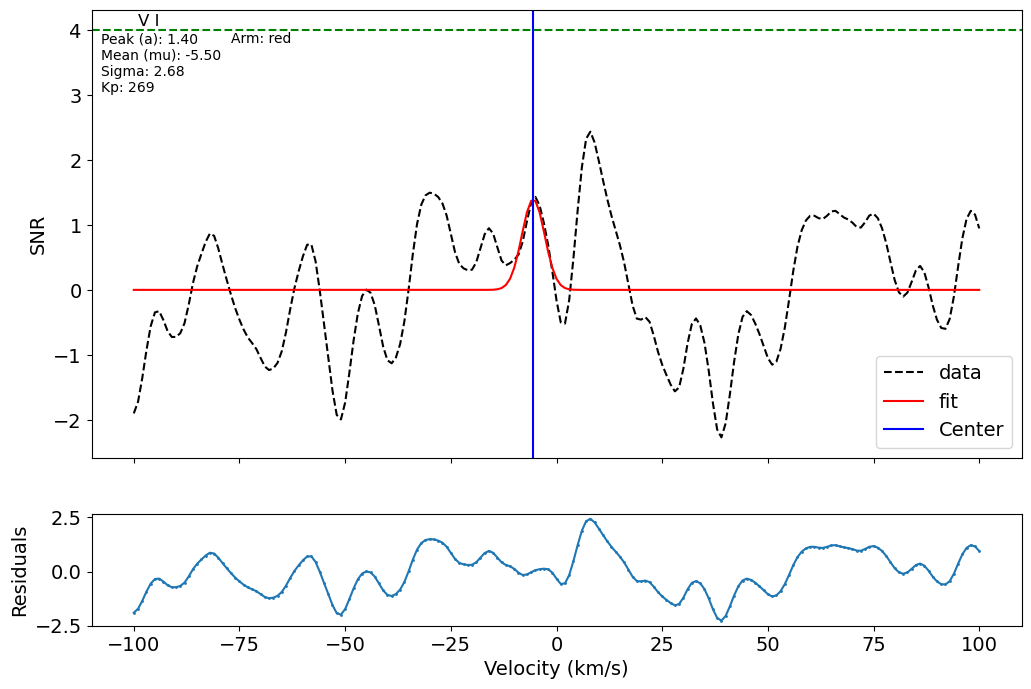

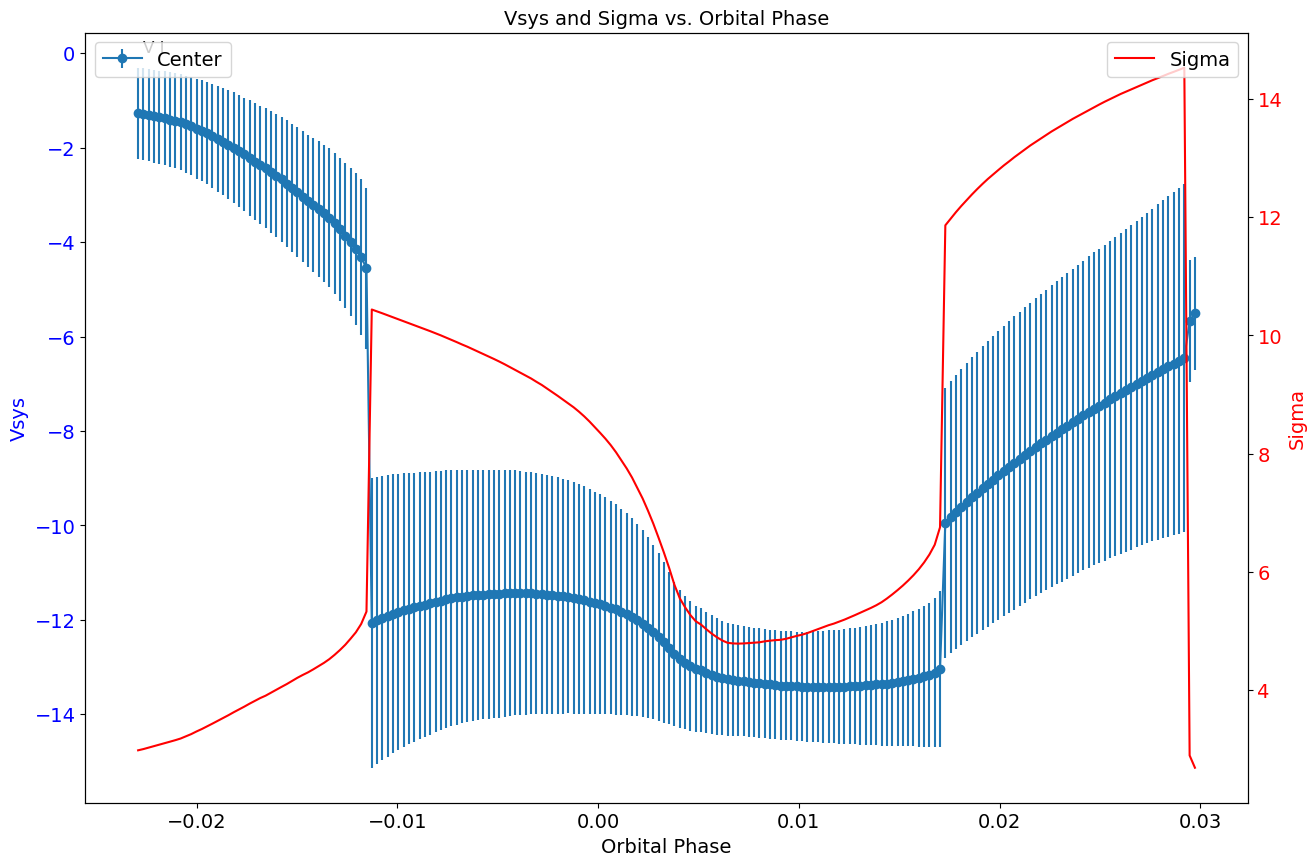

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

In [13]:
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'V I', 5.632e-09, False, True, True, 'ccf')

### V I Discussion

- Red arm
	- SNR: 2.79
	- Vsys: -3.21 km/s
	- Sigma: 2.68 km/s
	- Kp: 211
		
- Blue arm
	- SNR: 1.39
	- Vsys: -5.50 km/s
	- Sigma: 2.68 km/s
	- Kp: 269
		
		
- As an example, I threw in a nondetection here. At no point does Vanadium reach the 4-sigma threshold for signal detection. Although the Gaussian fit parameters are realistic,  the Vsys/sigma vs orbital phase shows erratic features.


## Gaussian fits of 1D slices of red and blue arms of Ca I

/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of Ca...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:680: RuntimeWarning: invalid value encountered in sqrt
  kernel = 1. / (np.pi * np.sqrt(1. - velocities**2 / profile_width**2))


Now running the  blue  data for  20190504
The maximum total SNR is  1420.901987322645


/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)
/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Selected SNR: 3.429060340249697 
 Selected Vsys: 0.5905971139030122 
 Selected sigma: 4.616132507240095 
 Selected Kp: 131
Now running the  red  data for  20190504
The maximum total SNR is  7744.3228985129235


/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1063: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[:,this_one[s]]/corrected_flux[:,this_one[s]]
/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1081: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[ep,this_one]/corrected_flux[ep,this_one]
/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)


Selected SNR: 4.449790804859396 
 Selected Vsys: 0.4745748531592612 
 Selected sigma: 4.6292012925021115 
 Selected Kp: 167
Now combining all of the data


<Figure size 640x480 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

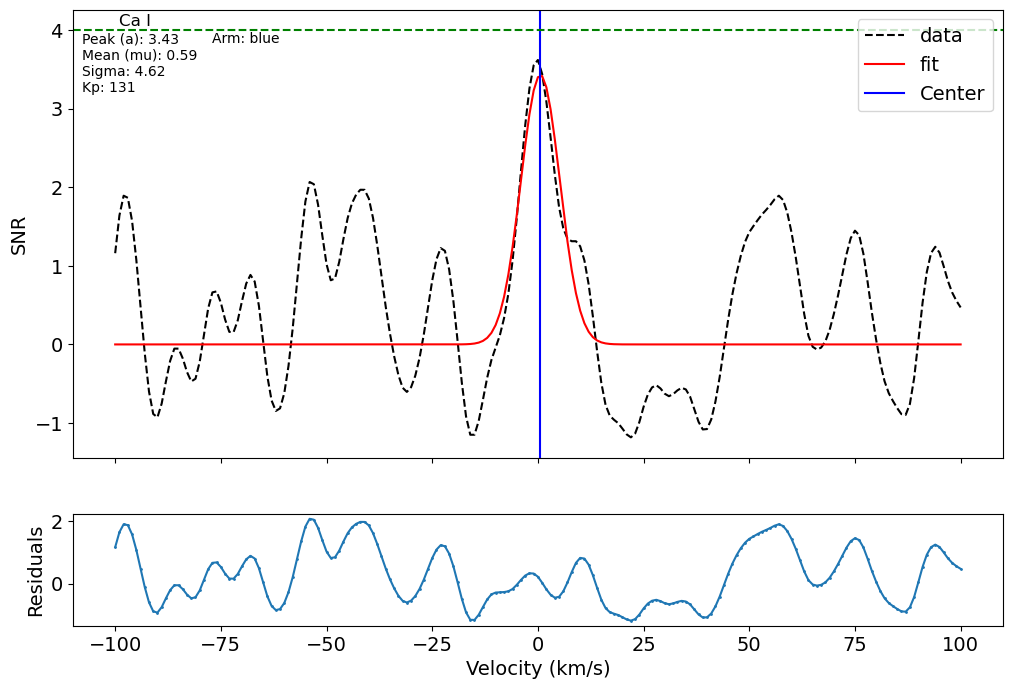

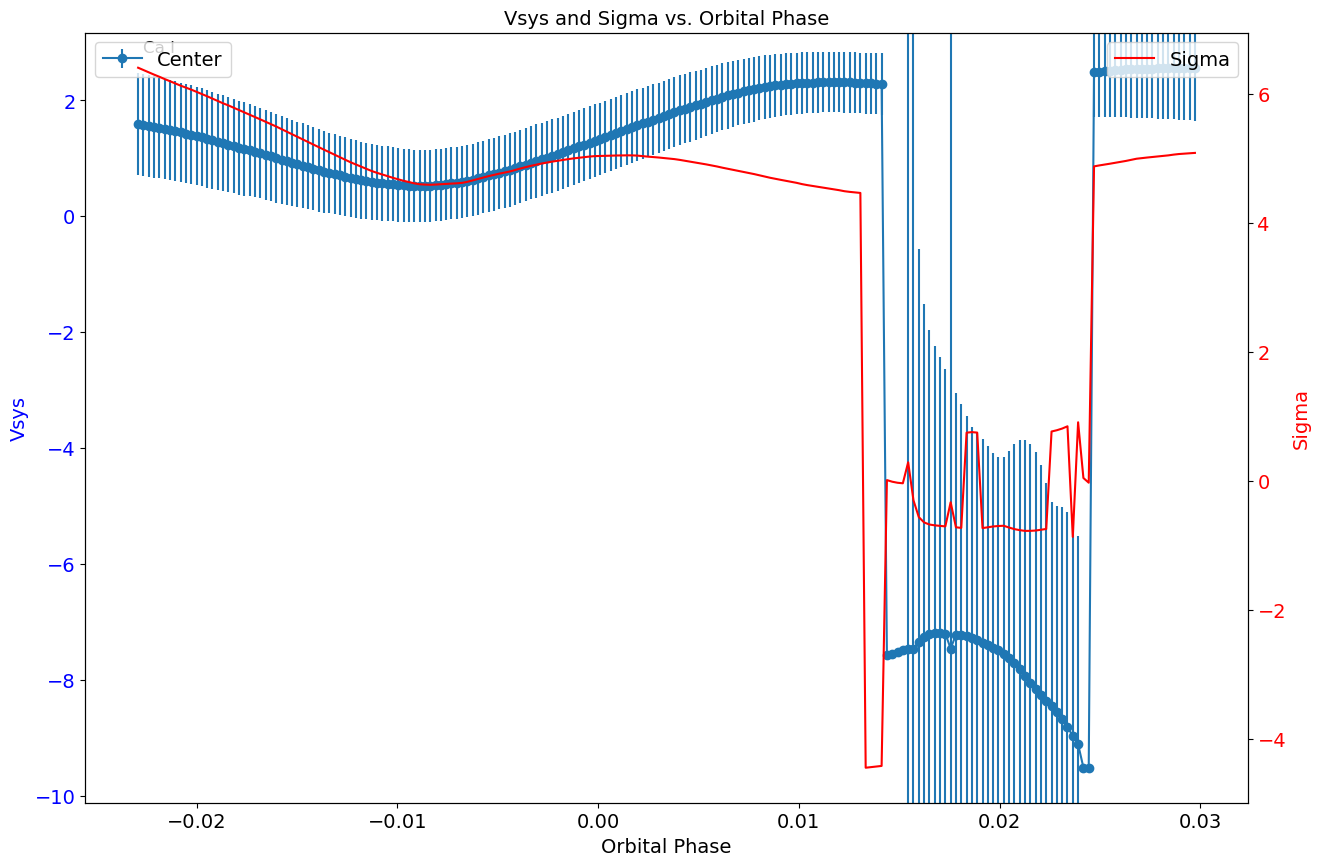

<Figure size 700x700 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

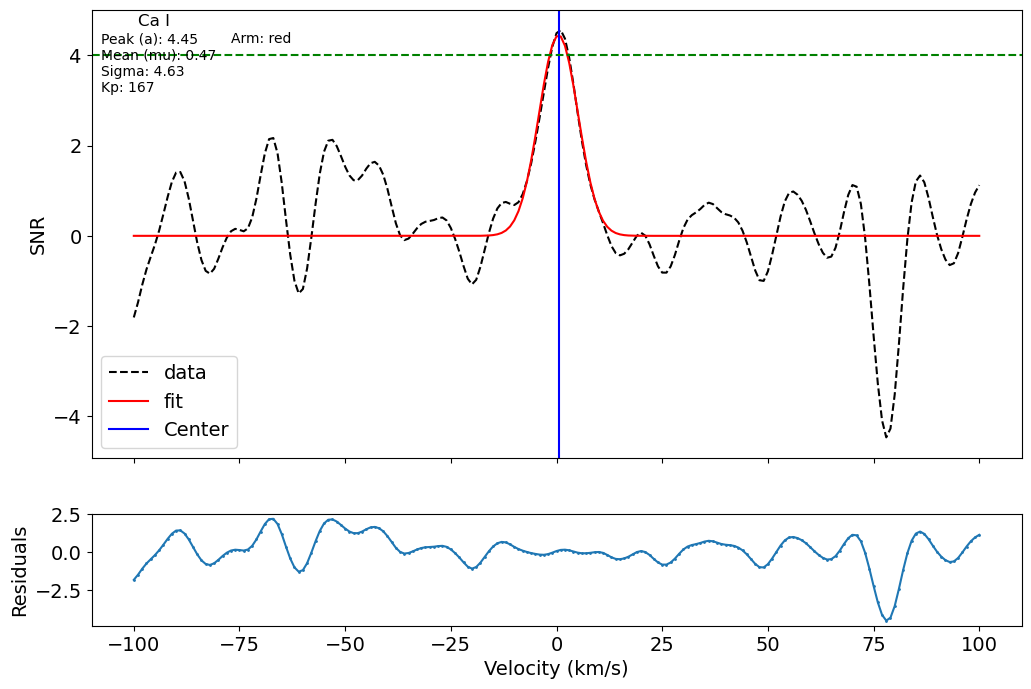

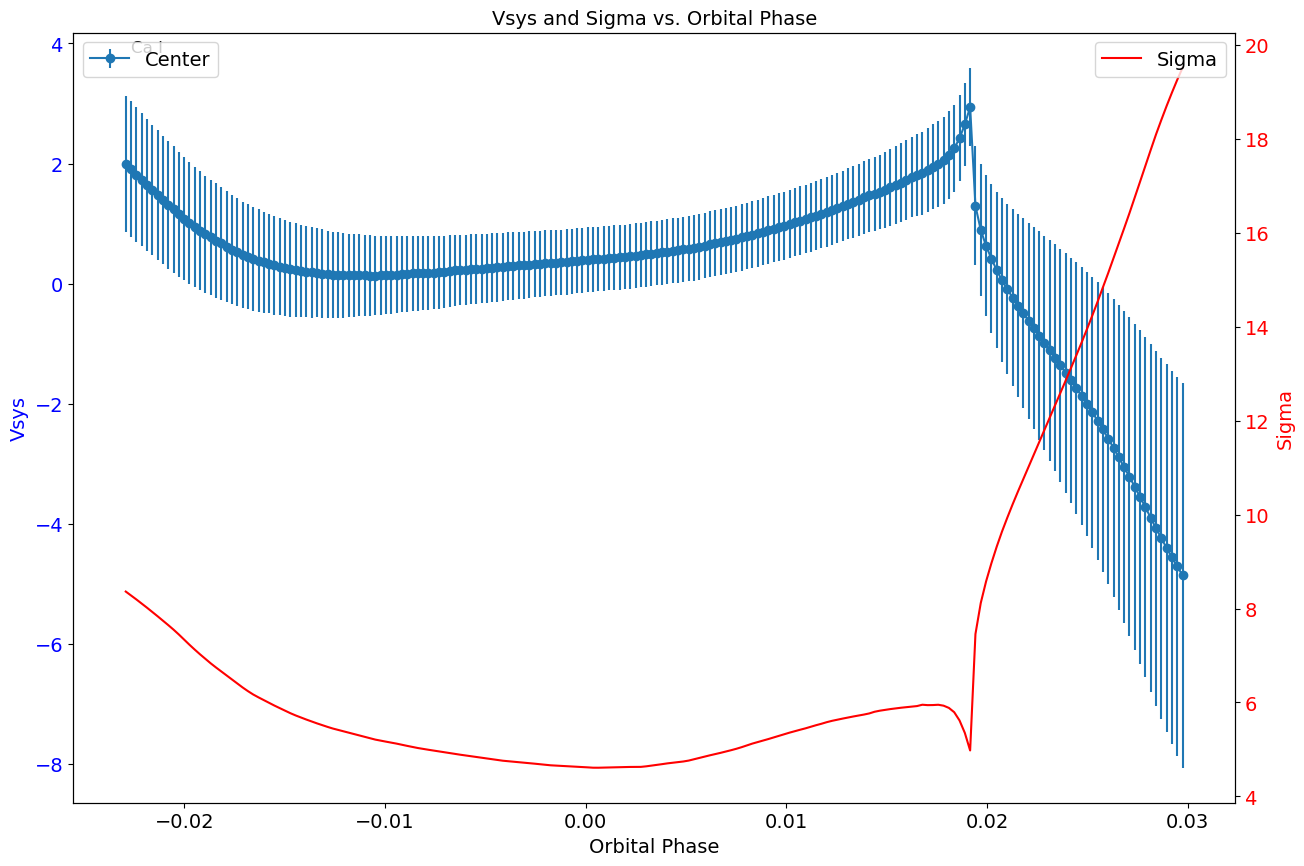

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

In [14]:
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Ca I', 2.101e-08, False, True, True, 'ccf')

### Ca I Discussion
- Red arm
	- SNR: 3.42
	- Vsys: 0.59 km/s
	- Sigma: 4.61 km/s
	- Kp: 131

- Blue arm
	- SNR: 4.44
	- Vsys: 0.47 km/s
	- Sigma: 4.62 km/s
	- Kp: 167

- Limb Asymmetry analysis
	- The blue arm is beyond the detection threshold, whereas the red arm is close, but does not meet, the detection threshold. Both Vsys's are near-zero and barely vary. Additionally, their sigmas are virtually equal. This detection is a good example of one that possesses very few assymmetries, with one caveat: In both arms, there is a strong shift in the Vsys/Sigma vs orbital phase curves around the 0.015 phase mark, leading me to believe there was an error in observation during this time.

### Conclusions

I have successfully fit gaussian profiles to the line profiles of several atomic species in KELT-20b's atmosphere. I have also analyzed the derived parameters and described all important takeaways for each species. Using Savel et al. as a reference, I've determined which atmospheric dynamics would be causing the limb asymmetries. Originally, I claimed that in this notebook I could quantitatively determine which of these mechanics are resulting in the plot's features, but that has proven to be a much too involved task for the scope of this notebook and time constraints I have to work in. I intend to continue working on diagnosing the mechanisms as a part of my research. Overall, this notebook was a success! Several of these visualizations will be employed when presenting my poster at the AAS meeting.